# Objectives

- [x] Train NN on half of dataset
- [x] Use results from this NN to remove false negatives above cut from this half of the data
- [x] Plot number of false negatives removed vs cut to select an appropriate cut range
- [x] Save new datasets for each cut in cut range (where false negatives have been removed in each from first half of dataset)
- [x] Train NNs on new datasets
- [ ] Evaluate the effectiveness of NNs on the yet unseen half of the dataset (which doesn't have any false negatives removed)
- [ ] Use the cut vs accuracy of NN to evaluate error


- [ ] Select NN trained on optimal data and attempt transfer learning on this data but in different  (maybe different thresholds)
- [ ] Evaluate this model on the remaining half of the dataset. Evaluate the differences in training time.

# Obvious Migdal Selection for Large Dataset

In [1]:
import tensorflow as tf
from os import listdir
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, LeakyReLU, Dropout

2022-09-04 09:33:11.916951: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [ ]:
def data_gen(file_nums, load_dir = '/vols/lz/lshanahan/data/numpy_noise/'):
    for i in file_nums: 
        data = np.expand_dims(np.load(f'{load_dir}/data_{i}.npy'),-1)
        labels = np.load(f'{load_dir}/labels_{i}.npy').astype(np.int32)
        for j in range(len(labels)):
            yield data[j], labels[j:j+1]
            
            
def data_gen_stack(file_nums, file_type_list, sqrt_scale= None, load_dir = '/vols/lz/lshanahan/data/numpy_noise/'):
    if sqrt_scale == None:
        sqrt_scale = [0 for f in file_type_list]
    for i in file_nums: 
        data = np.stack([np.sqrt(np.load(f'{load_dir}/data_{i}_noise'+f.decode('utf-8')+'.npy')) if s \
                               else np.load(f'{load_dir}/data_{i}_noise'+f.decode('utf-8')+'.npy') \
                               for f,s in zip(file_type_list,sqrt_scale)],axis=-1)
        labels = np.load(f'{load_dir}/labels_{i}.npy').astype(np.int32)
        for j in range(len(labels)):
            yield data[j,:,:,:], labels[j:j+1]

In [ ]:
def opt_model(file_type_list):
    opt_model = Sequential([
        Conv2D(10, kernel_size=(3,3), input_shape=(184,184,len(file_type_list)), padding='same'),
        LeakyReLU(),
        MaxPooling2D(),
        Conv2D(30, kernel_size=(3,3), padding='same'),
        LeakyReLU(),
        MaxPooling2D(),
        Conv2D(30, kernel_size=(3,3), padding='same'),
        LeakyReLU(),
        MaxPooling2D(),
        Flatten(),
        Dropout(0.05),
        Dense(20, kernel_regularizer = tf.keras.regularizers.L1L2(0.05,0.1)),
        LeakyReLU(),
        Dropout(0.05),
        Dense(10, kernel_regularizer = tf.keras.regularizers.L1L2(0.05,0.1)),
        LeakyReLU(),
        Dense(1, activation='sigmoid'),
    ], name='opt_model')
    return opt_model

In [ ]:
file_nums = list(range(18))
np.random.shuffle(file_nums)
file_type_list = ['_0.0_threshold', '_2.0_threshold', '_4.0_threshold',]
sqrt_scale = [0,0,0]
split = 13
train_dataset = tf.data.Dataset.from_generator(data_gen_stack, 
                                        args = (file_nums[:split], file_type_list),
                                        output_shapes=(tf.TensorShape((184,184,len(file_type_list))),tf.TensorShape(1)), 
                                        output_types=(tf.float64,tf.int32))

train_data_batch = train_dataset.batch(50)

test_dataset = tf.data.Dataset.from_generator(data_gen_stack, 
                                        args = (file_nums[split:], file_type_list),
                                        output_shapes=(tf.TensorShape((184,184,len(file_type_list))),tf.TensorShape(1)), 
                                        output_types=(tf.float64,tf.int32))

test_data_batch = test_dataset.batch(50)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', restore_best_weights=True, patience=15)

model = opt_model(file_type_list)

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy',metrics=['accuracy'])
model.fit(train_data_batch, epochs=250, validation_data=test_data_batch,callbacks=[callback],\
         verbose = 1)

We want to test it on both the reduced dataset and the original dataset. That is why we've split 50:50.

In [ ]:
# model.save('obd_mod_1.h5')

Load in all datapoints using generator. Don't do dataset just use generator. Test on some and 

# False Negatives vs. Obvious Cut

I want to find out how much of the data is removed for each obvious cut. Just do the same as before except save the size of new data for each cut and don't save files.

In [ ]:
import tensorflow as tf
from os import listdir
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, LeakyReLU, Dropout

In [ ]:
from tensorflow.keras.models import load_model
model = load_model("/vols/lz/lshanahan/obd_mod_1.h5")

In [ ]:
def data_gen_stack(file_nums, file_type_list, sqrt_scale= None, load_dir = '/vols/lz/lshanahan/data/numpy_noise/'):
    if sqrt_scale == None:
        sqrt_scale = [0 for f in file_type_list]
    for i in file_nums: 
        data = np.stack([np.sqrt(np.load(f'{load_dir}/data_{i}_noise'+f.decode('utf-8')+'.npy')) if s \
                               else np.load(f'{load_dir}/data_{i}_noise'+f.decode('utf-8')+'.npy') \
                               for f,s in zip(file_type_list,sqrt_scale)],axis=-1)
        labels = np.load(f'{load_dir}/labels_{i}.npy').astype(np.int32)
        for j in range(len(labels)):
            yield data[j,:,:,:], labels[j:j+1]

In [ ]:
file_nums = list(range(18))
file_type_list = ['', '_0.0_threshold', '_1.0_threshold', '_2.0_threshold', '_3.0_threshold', '_4.0_threshold', \
                  '_5.0_threshold', '_sub_bg', '_sqrt_sub_bg']

tot_dataset = tf.data.Dataset.from_generator(data_gen_stack, 
                                        args = (file_nums, file_type_list),
                                        output_shapes=(tf.TensorShape((184,184,len(file_type_list))),tf.TensorShape(1)), 
                                        output_types=(tf.float64,tf.int32))

I'll have to submit this to the queue and save the arrays so that I can plot them later.

In [ ]:
count = 0
cut = 0.01
false_neg_count = []
total_count = []
save_dir = '/vols/lz/lshanahan/data/numpy_obvs/'

for tdn in tot_dataset:
    total_count.append(1)
    count += 1
    if count%3000 == 0:
        print(f'Completed {count//3000} / {18}')
    data, label = tdn
    data = np.expand_dims(data, axis=0)
    input_dat = data[:,:,:,[1,3,5]]
    prob = model(input_dat).numpy()
    if prob > cut and label.numpy() < cut:
        false_neg_count.append(1)
    else:
        pass

In [ ]:
print(len(false_neg_count)*100/len(total_count))

## Writing code to submit to queue

In [ ]:
import tensorflow as tf
from os import listdir
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, LeakyReLU, Dropout
from tensorflow.keras.models import load_model
model = load_model("/vols/lz/lshanahan/obd_mod_1.h5")


#############################################            

def data_gen_stack(file_nums, file_type_list, sqrt_scale= None, load_dir = '/vols/lz/lshanahan/data/numpy_noise/'):
    if sqrt_scale == None:
        sqrt_scale = [0 for f in file_type_list]
    for i in file_nums: 
        data = np.stack([np.sqrt(np.load(f'{load_dir}/data_{i}_noise'+f.decode('utf-8')+'.npy')) if s \
                               else np.load(f'{load_dir}/data_{i}_noise'+f.decode('utf-8')+'.npy') \
                               for f,s in zip(file_type_list,sqrt_scale)],axis=-1)
        labels = np.load(f'{load_dir}/labels_{i}.npy').astype(np.int32)
        for j in range(len(labels)):
            yield data[j,:,:,:], labels[j:j+1]
            
            
#############################################            
            
file_nums = list(range(17))
file_type_list = ['', '_0.0_threshold', '_1.0_threshold', '_2.0_threshold', '_3.0_threshold', '_4.0_threshold', \
                  '_5.0_threshold', '_sub_bg', '_sqrt_sub_bg']

tot_dataset = tf.data.Dataset.from_generator(data_gen_stack, 
                                        args = (file_nums, file_type_list),
                                        output_shapes=(tf.TensorShape((184,184,len(file_type_list))),tf.TensorShape(1)), 
                                        output_types=(tf.float64,tf.int32))


#############################################            

cut_range = [0.001,0.005,0.007,0.01,0.015,0.02,0.035,0.05,0.07,0.1,0.2]
fn_rate_list = []

for i in cut_range:
    
    count = 0
    cut = i
    false_neg_count = []
    total_count = []
    save_dir = '/vols/lz/lshanahan/Big_data/'
    print()
    print(f'Computing for cut = {cut}')
    print()
    for tdn in tot_dataset:
        data, label = tdn
        data = np.expand_dims(data, axis=0)
        input_dat = data[:,:,:,[1,3,5]]
        prob = model(input_dat).numpy()
        if prob > cut and label.numpy() < cut:
            false_neg_count.append(1)
        else:
            pass
        total_count.append(1)
        count += 1
        if count%3000 == 0:
            print(f'Completed {count//3000}')
            
    fn_rate_list.append(len(false_neg_count)*100/len(total_count))

np.save(f'{save_dir}fnr_list.npy', fn_rate_list)
np.save(f'{save_dir}cut_list.npy', cut_range)

## Plotting Results from Queue

In [1]:
from matplotlib import pyplot as plt
import numpy as np

In [2]:
cut_list = np.load('cut_list.npy')
fnr_list = np.load('fnr_list.npy')

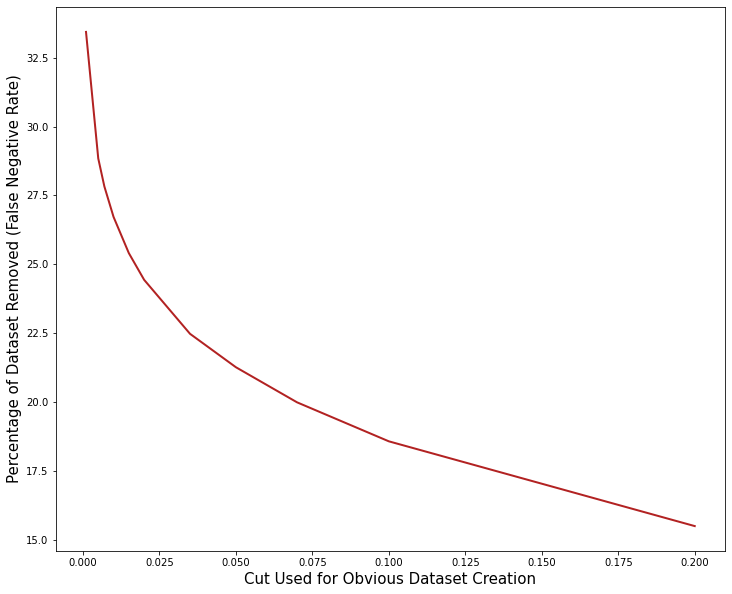

In [4]:
plt.figure(figsize=(12,10))
plt.plot(cut_list,fnr_list,linewidth=2,c='firebrick')
plt.xlabel('Cut Used for Obvious Dataset Creation',fontsize=15)
plt.ylabel('Percentage of Dataset Removed (False Negative Rate)',fontsize=15);

- Plot captions no smaller than text
- Easy to understand captions
- Spacing, take colorblindness into account
- Ask Tim for Migdal template
- Save figures as pdf


- False positives per Migdal

# Loading trained model and selecting data

Choose the optimal cut as chosen when plotting above

In [ ]:
import tensorflow as tf
from os import listdir
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, LeakyReLU, Dropout

In [ ]:
from tensorflow.keras.models import load_model
model = load_model("/vols/lz/lshanahan/obd_mod_1.h5")

Here's what I'll do:

- Using generator, go through all the data.
- If below a cut, append to an array
- Once array becomes 3000 in size, save that array
- Include a counter to name each newly saved array
- Once at the end of the dataset, save array anyway (despite being <3000)

In [ ]:
def data_gen_stack(file_nums, file_type_list, sqrt_scale= None, load_dir = '/vols/lz/lshanahan/data/numpy_noise/'):
    if sqrt_scale == None:
        sqrt_scale = [0 for f in file_type_list]
    for i in file_nums: 
        data = np.stack([np.sqrt(np.load(f'{load_dir}/data_{i}_noise'+f.decode('utf-8')+'.npy')) if s \
                               else np.load(f'{load_dir}/data_{i}_noise'+f.decode('utf-8')+'.npy') \
                               for f,s in zip(file_type_list,sqrt_scale)],axis=-1)
        labels = np.load(f'{load_dir}/labels_{i}.npy').astype(np.int32)
        for j in range(len(labels)):
            yield data[j,:,:,:], labels[j:j+1]

In [ ]:
file_nums = list(range(17))
file_type_list = ['', '_0.0_threshold', '_1.0_threshold', '_2.0_threshold', '_3.0_threshold', '_4.0_threshold', \
                  '_5.0_threshold', '_sub_bg', '_sqrt_sub_bg']

tot_dataset = tf.data.Dataset.from_generator(data_gen_stack, 
                                        args = (file_nums, file_type_list),
                                        output_shapes=(tf.TensorShape((184,184,len(file_type_list))),tf.TensorShape(1)), 
                                        output_types=(tf.float64,tf.int32))

In [ ]:
count = 0
cut = 0.01
new_data = []
new_labels = []
save_dir = '/vols/lz/lshanahan/data/numpy_obvs/'

for tdn in tot_dataset:
    data, label = tdn
    data = np.expand_dims(data, axis=0)
    input_dat = data[:,:,:,[1,3,5]]
    prob = model(input_dat).numpy()
    if prob > cut and label.numpy() < cut:
        pass
    else:
        new_data.append(data)
        new_labels.append(label.numpy())
    if len(new_data) == 3000:
        for i in range(len(file_type_list)):
            np.save(f'{save_dir}data_{count}_obvs{file_type_list[i]}.npy', [x[:,:,:,i] for x in new_data])
        np.save(f'{save_dir}labels_{count}_obvs.npy', new_labels)
        new_data = []
        new_labels = []
        print(f'Saved {count}/18')
        count+=1

# Loading Obvious Data and Training

In [ ]:
import tensorflow as tf
from os import listdir
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, LeakyReLU, Dropout

In [ ]:
testdat = np.load('/vols/lz/lshanahan/data/numpy_obvs/data_0_obvs_sub_bg.npy')
testlab = np.load('/vols/lz/lshanahan/data/numpy_obvs/labels_0_obvs.npy')

In [ ]:
np.shape(testdat)

In [ ]:
np.shape(np.squeeze(testdat,axis=1))

In [ ]:
np.shape(testlab)

In [ ]:
np.shape(np.squeeze(testlab,axis=1))

In [ ]:
testdat = np.load('/vols/lz/lshanahan/data/numpy_noise/data_0_noise.npy')
testlab = np.load('/vols/lz/lshanahan/data/numpy_noise/labels_0.npy')

In [ ]:
np.shape(testdat)

In [ ]:
np.shape(testlab)

In [ ]:
def data_gen_obvs(file_nums, file_type_list, sqrt_scale= None, load_dir = '/vols/lz/lshanahan/data/numpy_obvs/'):
    if sqrt_scale == None:
        sqrt_scale = [0 for f in file_type_list]
    for i in file_nums: 
        data = np.stack([np.sqrt(np.squeeze(np.load(f'{load_dir}/data_{i}_obvs'+f.decode('utf-8')+'.npy'),axis=1)) if s \
                               else np.squeeze(np.load(f'{load_dir}/data_{i}_obvs'+f.decode('utf-8')+'.npy'),axis=1) \
                               for f,s in zip(file_type_list,sqrt_scale)],axis=-1)
        labels = np.squeeze(np.load(f'{load_dir}/labels_{i}_obvs.npy').astype(np.int32),axis=1)
        for j in range(len(labels)):
            yield data[j,:,:,:], labels[j:j+1]

In [ ]:
def opt_model(file_type_list):
    opt_model = Sequential([
        Conv2D(10, kernel_size=(3,3), input_shape=(184,184,len(file_type_list)), padding='same'),
        LeakyReLU(),
        MaxPooling2D(),
        Conv2D(30, kernel_size=(3,3), padding='same'),
        LeakyReLU(),
        MaxPooling2D(),
        Conv2D(30, kernel_size=(3,3), padding='same'),
        LeakyReLU(),
        MaxPooling2D(),
        Flatten(),
        Dropout(0.05),
        Dense(20, kernel_regularizer = tf.keras.regularizers.L1L2(0.05,0.1)),
        LeakyReLU(),
        Dropout(0.05),
        Dense(10, kernel_regularizer = tf.keras.regularizers.L1L2(0.05,0.1)),
        LeakyReLU(),
        Dense(1, activation='sigmoid'),
    ], name='opt_model')
    return opt_model

In [ ]:
file_nums = list(range(13))
np.random.shuffle(file_nums)
file_type_list = ['_0.0_threshold', '_2.0_threshold', '_4.0_threshold',]
sqrt_scale = [0,0,0]
split = 10
train_dataset = tf.data.Dataset.from_generator(data_gen_obvs, 
                                        args = (file_nums[:split], file_type_list),
                                        output_shapes=(tf.TensorShape((184,184,len(file_type_list))),tf.TensorShape(1)), 
                                        output_types=(tf.float64,tf.int32))

train_data_batch = train_dataset.batch(50)

test_dataset = tf.data.Dataset.from_generator(data_gen_obvs, 
                                        args = (file_nums[split:], file_type_list),
                                        output_shapes=(tf.TensorShape((184,184,len(file_type_list))),tf.TensorShape(1)), 
                                        output_types=(tf.float64,tf.int32))

test_data_batch = test_dataset.batch(50)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', restore_best_weights=True, patience=20)

model = opt_model(file_type_list)

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy',metrics=['accuracy'])
model.fit(train_data_batch, epochs=250, validation_data=test_data_batch,callbacks=[callback],\
         verbose = 1)

In [ ]:
model.save('trained_on_obvs_mod.h5')

# Testing on Remaining Unaltered Data

In [ ]:
import tensorflow as tf
from os import listdir
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, LeakyReLU, Dropout

In [ ]:
from tensorflow.keras.models import load_model
model = load_model("/vols/lz/lshanahan/obd_mod_1.h5")

In [ ]:
def data_gen_stack(file_nums, file_type_list, sqrt_scale= None, load_dir = '/vols/lz/lshanahan/data/numpy_noise/'):
    if sqrt_scale == None:
        sqrt_scale = [0 for f in file_type_list]
    for i in file_nums: 
        data = np.stack([np.sqrt(np.load(f'{load_dir}/data_{i}_noise'+f.decode('utf-8')+'.npy')) if s \
                               else np.load(f'{load_dir}/data_{i}_noise'+f.decode('utf-8')+'.npy') \
                               for f,s in zip(file_type_list,sqrt_scale)],axis=-1)
        labels = np.load(f'{load_dir}/labels_{i}.npy').astype(np.int32)
        for j in range(len(labels)):
            yield data[j,:,:,:], labels[j:j+1]

In [ ]:
file_nums = list(range(19,36))
np.random.shuffle(file_nums)
file_type_list = ['_0.0_threshold', '_2.0_threshold', '_4.0_threshold',]
sqrt_scale = [0,0,0]

total_dataset = tf.data.Dataset.from_generator(data_gen_stack, 
                                        args = (file_nums, file_type_list),
                                        output_shapes=(tf.TensorShape((184,184,len(file_type_list))),tf.TensorShape(1)), 
                                        output_types=(tf.float64,tf.int32))

In [ ]:
prob_list, lab_list = [],[]

for tdn in total_dataset:
    data, label = tdn
    data = np.expand_dims(data, axis=0)
    prob = model(data).numpy()
    prob_list.append(prob)
    lab_list.append(label)

In [ ]:
np.shape(prob_list)

In [ ]:
np.shape(lab_list)

In [ ]:
cut = 0.1
fps, nrs, mig, cor = [],[],[],[]

for i in range(len(prob_list)):
    if prob_list[i] < cut and lab_list[i] == 1:
        fps.append(i)
    if lab_list[i] == 1:
        nrs.append(i)
    if lab_list[i] == 0:
        mig.append(i)
    if prob_list[i] < cut and lab_list[i] == 0:
        cor.append(i)
        
print('False Positives: ', len(fps))
print('Number of NRs: ', len(nrs))
print('False Positive Rate: ', len(fps)*100/len(nrs))
print('False Positives per Migdal: ', ((len(fps)/len(nrs))*10e6)/15)
print('Accuracy: ', len(cor)*100/len(mig))

Obvious cut of 0.1

False Positives:  114 \
Number of NRs:  21197 \
False Positive Rate:  0.5378119545218663 \
False Positives per Migdal:  3585.413030145776 \
Accuracy:  59.01022357038535

- Tidy up above code
- Run first net
- Plot number of false negatives vs obvious cut
- Use above to pick range of cuts for next part - pick sensible region to run (send to Tim)
- Run one NN see how long it takes to pick number
- Plot accuracy, number of false positives per migdal etc of second NN vs obvious cut
- Submit to queue
- Focus just on 0, 2 ,4 threshold (we already showed it doesnt affect acc much so don't need to waste time optimising)

# Creating Folders for Each Cut

In [ ]:
import os

cut_list = [0.001, 0.002, 0.003, 0.004, 0.006, 0.008, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.15, 0.2]

for cut in cut_list:
    os.mkdir(f"/vols/lz/lshanahan/data/obvs_cut_{cut}")

# Writing into QSub Format

In [ ]:
import tensorflow as tf
from os import listdir
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, LeakyReLU, Dropout
from tensorflow.keras.models import load_model

model = load_model("/vols/lz/lshanahan/obd_mod_1.h5")

def data_gen_stack(file_nums, file_type_list, sqrt_scale= None, load_dir = '/vols/lz/lshanahan/data/numpy_noise/'):
    if sqrt_scale == None:
        sqrt_scale = [0 for f in file_type_list]
    for i in file_nums: 
        data = np.stack([np.sqrt(np.load(f'{load_dir}/data_{i}_noise'+f.decode('utf-8')+'.npy')) if s \
                               else np.load(f'{load_dir}/data_{i}_noise'+f.decode('utf-8')+'.npy') \
                               for f,s in zip(file_type_list,sqrt_scale)],axis=-1)
        labels = np.load(f'{load_dir}/labels_{i}.npy').astype(np.int32)
        for j in range(len(labels)):
            yield data[j,:,:,:], labels[j:j+1]
            
            
file_nums = list(range(18))
file_type_list = ['', '_0.0_threshold', '_1.0_threshold', '_2.0_threshold', '_3.0_threshold', '_4.0_threshold', \
                  '_5.0_threshold', '_sub_bg', '_sqrt_sub_bg']

tot_dataset = tf.data.Dataset.from_generator(data_gen_stack, 
                                        args = (file_nums, file_type_list),
                                        output_shapes=(tf.TensorShape((184,184,len(file_type_list))),tf.TensorShape(1)), 
                                        output_types=(tf.float64,tf.int32))


cut_list = [0.001, 0.002, 0.003, 0.004, 0.006, 0.008, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.15, 0.2]
count_list = []

for k in cut_list:

    count = 0
    cut = k
    new_data = []
    new_labels = []
    save_dir = f'/vols/lz/lshanahan/data/obvs_cut_{k}/'

    print()
    print(f'Cut: {cut}')
    print()

    for tdn in tot_dataset:
        data, label = tdn
        data = np.expand_dims(data, axis=0)
        input_dat = data[:,:,:,[1,3,5]]
        prob = model(input_dat).numpy()
        if prob > cut and label.numpy() < cut:
            pass
        else:
            new_data.append(data)
            new_labels.append(label.numpy())
        if len(new_data) == 3000:
            for i in range(len(file_type_list)):
                np.save(f'{save_dir}data_{count}_obvs{file_type_list[i]}.npy', [x[:,:,:,i] for x in new_data])
            np.save(f'{save_dir}labels_{count}_obvs.npy', new_labels)
            new_data = []
            new_labels = []
            print(f'Saved {count}/18')
            count+=1
    
    count_list.append(count)
    
np.save(f'/vols/lz/lshanahan/data/count_list', count_list)

# Training on Each Obvious Dataset

Objectives

- Loop over cut values
- In each loop specify new generator with different load_dir
- Train using that generator
- Save optimised model with cut in name
- Later, I can loop over all the saved models and test using them

I'll submit the code below to the queue.

In [ ]:
import tensorflow as tf
from os import listdir
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, LeakyReLU, Dropout

cut_list = [0.001, 0.002, 0.003, 0.004, 0.006, 0.008, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.15, 0.2]
count_list = np.load('/vols/lz/lshanahan/data/count_list.npy')

for x in range(len(cut_list)):
    
    def data_gen_obvs(file_nums, file_type_list, sqrt_scale= None, load_dir = f'/vols/lz/lshanahan/data/obvs_cut_{cut_list[x]}/'):
        if sqrt_scale == None:
            sqrt_scale = [0 for f in file_type_list]
        for i in file_nums: 
            data = np.stack([np.sqrt(np.squeeze(np.load(f'{load_dir}/data_{i}_obvs'+f.decode('utf-8')+'.npy'),axis=1)) if s \
                                   else np.squeeze(np.load(f'{load_dir}/data_{i}_obvs'+f.decode('utf-8')+'.npy'),axis=1) \
                                   for f,s in zip(file_type_list,sqrt_scale)],axis=-1)
            labels = np.squeeze(np.load(f'{load_dir}/labels_{i}_obvs.npy').astype(np.int32),axis=1)
            for j in range(len(labels)):
                yield data[j,:,:,:], labels[j:j+1]
            
            
    def opt_model(file_type_list):
        opt_model = Sequential([
            Conv2D(10, kernel_size=(3,3), input_shape=(184,184,len(file_type_list)), padding='same'),
            LeakyReLU(),
            MaxPooling2D(),
            Conv2D(30, kernel_size=(3,3), padding='same'),
            LeakyReLU(),
            MaxPooling2D(),
            Conv2D(30, kernel_size=(3,3), padding='same'),
            LeakyReLU(),
            MaxPooling2D(),
            Flatten(),
            Dropout(0.05),
            Dense(20, kernel_regularizer = tf.keras.regularizers.L1L2(0.05,0.1)),
            LeakyReLU(),
            Dropout(0.05),
            Dense(10, kernel_regularizer = tf.keras.regularizers.L1L2(0.05,0.1)),
            LeakyReLU(),
            Dense(1, activation='sigmoid'),
        ], name='opt_model')
        return opt_model
    
    
    file_nums = list(range(count_list[x]))
    np.random.shuffle(file_nums)
    file_type_list = ['_0.0_threshold', '_2.0_threshold', '_4.0_threshold',]
    sqrt_scale = [0,0,0]
    split = 10
    train_dataset = tf.data.Dataset.from_generator(data_gen_obvs, 
                                            args = (file_nums[:split], file_type_list),
                                            output_shapes=(tf.TensorShape((184,184,len(file_type_list))),tf.TensorShape(1)), 
                                            output_types=(tf.float64,tf.int32))

    train_data_batch = train_dataset.batch(50)

    test_dataset = tf.data.Dataset.from_generator(data_gen_obvs, 
                                            args = (file_nums[split:], file_type_list),
                                            output_shapes=(tf.TensorShape((184,184,len(file_type_list))),tf.TensorShape(1)), 
                                            output_types=(tf.float64,tf.int32))

    test_data_batch = test_dataset.batch(50)

    callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', restore_best_weights=True, patience=20)

    model = opt_model(file_type_list)

    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='binary_crossentropy',metrics=['accuracy'])
    model.fit(train_data_batch, epochs=250, validation_data=test_data_batch,callbacks=[callback],\
             verbose = 1)

    model.save(f'/vols/lz/lshanahan/Big_data/trained_on_obs_mods/obvs_mod_{cut_list[x]}.h5')

# Evaluating Each Model on Unseen Data

In [3]:
list(range(18,36))

[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]

In [4]:
list(range(18))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

In [6]:
import tensorflow as tf
from os import listdir
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, LeakyReLU, Dropout

from tensorflow.keras.models import load_model



def data_gen_stack(file_nums, file_type_list, sqrt_scale= None, load_dir = '/vols/lz/lshanahan/data/numpy_noise/'):
    if sqrt_scale == None:
        sqrt_scale = [0 for f in file_type_list]
    for i in file_nums: 
        data = np.stack([np.sqrt(np.load(f'{load_dir}/data_{i}_noise'+f.decode('utf-8')+'.npy')) if s \
                               else np.load(f'{load_dir}/data_{i}_noise'+f.decode('utf-8')+'.npy') \
                               for f,s in zip(file_type_list,sqrt_scale)],axis=-1)
        labels = np.load(f'{load_dir}/labels_{i}.npy').astype(np.int32)
        for j in range(len(labels)):
            yield data[j,:,:,:], labels[j:j+1]
            
file_nums = list(range(18,36))
np.random.shuffle(file_nums)
file_type_list = ['_0.0_threshold', '_2.0_threshold', '_4.0_threshold',]
sqrt_scale = [0,0,0]


total_dataset = tf.data.Dataset.from_generator(data_gen_stack, 
                                        args = (file_nums, file_type_list),
                                        output_shapes=(tf.TensorShape((184,184,len(file_type_list))),tf.TensorShape(1)), 
                                        output_types=(tf.float64,tf.int32))



cut_list = [0.001, 0.002, 0.003, 0.004, 0.006, 0.008, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.15, 0.2]
count_list = np.load('/vols/lz/lshanahan/data/count_list.npy')

false_pos_list, NR_list, FP_rate_list, accuracy_list = [],[],[],[]

for x in range(len(cut_list)):

    print(f'testing on {cut_list[x]}')
    
    model = load_model(f'/vols/lz/lshanahan/Big_data/trained_on_obs_mods/obvs_mod_{cut_list[x]}.h5')


    prob_list, lab_list = [],[]

    for tdn in total_dataset:
        data, label = tdn
        data = np.expand_dims(data, axis=0)
        prob = model(data).numpy()
        prob_list.append(prob)
        lab_list.append(label)
        if (len(lab_list) % 3000==0):
            print('Progress report...')


    cut = 0.1
    fps, nrs, mig, cor = [],[],[],[]

    for i in range(len(prob_list)):
        if prob_list[i] < cut and lab_list[i] == 1:
            fps.append(i)
        if lab_list[i] == 1:
            nrs.append(i)
        if lab_list[i] == 0:
            mig.append(i)
        if prob_list[i] < cut and lab_list[i] == 0:
            cor.append(i)

    print('False Positives: ', len(fps))
    print('Number of NRs: ', len(nrs))
    print('False Positive Rate: ', len(fps)*100/len(nrs))
    print('False Positives per Migdal: ', ((len(fps)/len(nrs))*10e6)/15)
    print('Accuracy: ', len(cor)*100/len(mig))
    
    
    false_pos_list.append(len(fps))
    NR_list.append(len(nrs))
    FP_rate_list.append(len(fps)*100/len(nrs))
    accuracy_list.append(len(cor)*100/len(mig))
    
np.save('Final_lists/false_pos_list.npy', false_pos_list)
np.save('Final_lists/NR_list.npy', NR_list)
np.save('Final_lists/FP_rate_list.npy', FP_rate_list)
np.save('Final_lists/false_pos_list.npy', accuracy_list)

testing on 0.001
Progress report...
Progress report...
Progress report...
Progress report...
Progress report...
Progress report...
Progress report...
Progress report...
Progress report...
Progress report...
Progress report...
Progress report...
Progress report...
Progress report...
Progress report...
Progress report...
Progress report...
False Positives:  64
Number of NRs:  29446
False Positive Rate:  0.21734700808259186
False Positives per Migdal:  1448.9800538839456
Accuracy:  50.41339143892803
testing on 0.002
Progress report...
Progress report...
Progress report...
Progress report...
Progress report...
Progress report...
Progress report...
Progress report...
Progress report...
Progress report...
Progress report...
Progress report...
Progress report...
Progress report...
Progress report...
Progress report...
Progress report...
False Positives:  56
Number of NRs:  29446
False Positive Rate:  0.19017863207226787
False Positives per Migdal:  1267.8575471484523
Accuracy:  48.31181525679

OSError: SavedModel file does not exist at: /vols/lz/lshanahan/Big_data/trained_on_obs_mods/obvs_mod_0.04.h5/{saved_model.pbtxt|saved_model.pb}

In [7]:
np.save('Final_lists/false_pos_list.npy', false_pos_list)
np.save('Final_lists/NR_list.npy', NR_list)
np.save('Final_lists/FP_rate_list.npy', FP_rate_list)
np.save('Final_lists/false_pos_list.npy', accuracy_list)

In [8]:
false_pos_list

[64, 56, 60, 63, 44, 90, 85, 101, 74]

In [9]:
NR_list

[29446, 29446, 29446, 29446, 29446, 29446, 29446, 29446, 29446]

In [10]:
accuracy_list

[50.41339143892803,
 48.311815256791434,
 47.93304280535983,
 50.87362033152772,
 45.64818963059504,
 52.7674825886857,
 55.85060888689773,
 53.83863479004602,
 50.86547468741091]

In [12]:
from matplotlib import pyplot as plt
import numpy as np

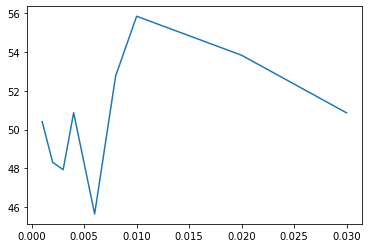

In [16]:
cut_list = [0.001, 0.002, 0.003, 0.004, 0.006, 0.008, 0.01, 0.02, 0.03]

plt.plot(cut_list,accuracy_list)

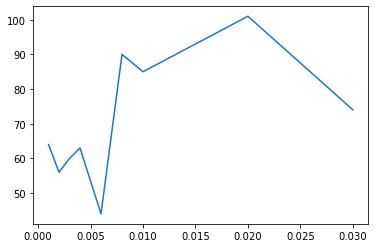

In [17]:
plt.plot(cut_list,false_pos_list)

In [39]:
fppm_list = []

for i in range(len(accuracy_list)):

    fps = false_pos_list[i]
    print(fps)
    acc = np.round(accuracy_list[i],2)
    print(acc)
    nrs = 29446
    
    fppm = (((fps/nrs)*10e6)/(30*(acc/100)))
    fppm_list.append(fppm)
    
np.save('Final_lists/fppm_list.npy', fppm_list)

64
50.41
56
48.31
60
47.93
63
50.87
44
45.65
90
52.77
85
55.85
101
53.84
74
50.87


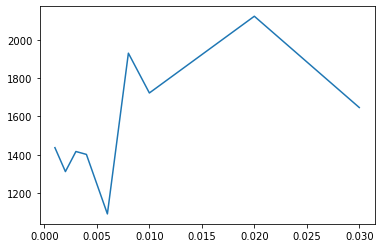

In [30]:
plt.plot(cut_list,fppm_list)

# Now Varying Second Cut

In [43]:
cut_list = np.arange(0,0.5,0.001)

In [44]:
cut_list = np.arange(0,0.5,0.001)
false_pos_list2, NR_list2, FP_rate_list2, accuracy_list2 = [],[],[],[]
            
for x in range(len(cut_list)):

    cut = cut_list[x]
    fps, nrs, mig, cor = [],[],[],[]

    for i in range(len(prob_list)):
        if prob_list[i] < cut and lab_list[i] == 1:
            fps.append(i)
        if lab_list[i] == 1:
            nrs.append(i)
        if lab_list[i] == 0:
            mig.append(i)
        if prob_list[i] < cut and lab_list[i] == 0:
            cor.append(i)

    print('progress')
    
    
    false_pos_list2.append(len(fps))
    NR_list2.append(len(nrs))
    FP_rate_list2.append(len(fps)*100/len(nrs))
    accuracy_list2.append(len(cor)*100/len(mig))
    
np.save('Final_lists/2ndNN_false_pos_list.npy', false_pos_list2)
np.save('Final_lists/2ndNN_NR_list.npy', NR_list2)
np.save('Final_lists/2ndNN_FP_rate_list.npy', FP_rate_list2)
np.save('Final_lists/2ndNN_false_pos_list.npy', accuracy_list2)

progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
p

In [45]:
len(accuracy_list2)

500

In [46]:
fppm_list = []

for i in range(len(accuracy_list2)):

    fps = false_pos_list2[i]
    print(fps)
    acc = np.round(accuracy_list2[i],2)
    print(acc)
    nrs = NR_list2[i]
    
    fppm = (((fps/nrs)*10e6)/(30*(acc/100)))
    fppm_list.append(fppm)
    
np.save('Final_lists/2ndcut_fppm_list.npy', fppm_list)

0
0.0
11
20.54
14
23.5
17
25.37
18
26.71
19
27.84
19
28.82
19
29.69
20
30.35
22
31.05
22
31.63
22
32.02
22
32.6
22
33.11
22
33.56
22
33.96
22
34.34
22
34.71
23
35.01
25
35.4
25
35.71
25
35.98
25
36.24
26
36.51
26
36.75
26
36.95
26
37.18
27
37.41
27
37.66
27
37.9
28
38.06
28
38.27
28
38.47
28
38.66
28
38.84
28
38.97
28
39.12
28
39.25
28
39.42
28
39.55
28
39.66
28
39.78
28
39.94
28
40.08
28
40.22
28
40.35
28
40.47
29
40.61
30
40.74
30
40.85
30
40.97
30
41.1
31
41.21
31
41.35
31
41.48
31
41.58
31
41.66
32
41.8
32
41.91
33
42.05
33
42.19
33
42.32
33
42.46
33
42.52
33
42.6
33
42.72
33
42.82
33
42.92
34
43.03
34
43.17
34
43.27
35
43.37
35
43.45
35
43.57
36
43.64
36
43.71
36
43.82
36
43.89
36
43.96
36
44.06
36
44.15
36
44.23
37
44.3
37
44.39
37
44.47
37
44.53
37
44.6
38
44.7
38
44.75
38
44.87
39
44.93
39
44.99
39
45.06
39
45.14
39
45.2
41
45.27
41
45.38
41
45.43
43
45.49
43
45.56
44
45.65
44
45.72
46
45.78
46
45.83
46
45.91
46
45.99
47
46.06
47
46.11
48
46.18
48
46.23
49
46.3
50
46.38
50
46.4

/tmp/ipykernel_3972/2047176568.py:11: RuntimeWarning: invalid value encountered in double_scalars
  fppm = (((fps/nrs)*10e6)/(30*(acc/100)))


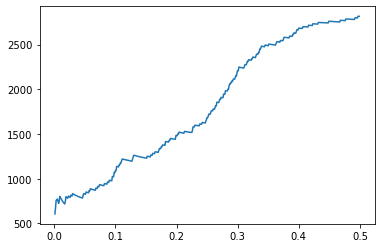

In [47]:
plt.plot(cut_list,fppm_list)

# Same Again With Smaller Range

In [54]:
cut_list = np.arange(0,0.01,0.0001)
false_pos_list3, NR_list3, FP_rate_list3, accuracy_list3 = [],[],[],[]
            
for x in range(len(cut_list)):

    cut = cut_list[x]
    fps, nrs, mig, cor = [],[],[],[]

    for i in range(len(prob_list)):
        if prob_list[i] < cut and lab_list[i] == 1:
            fps.append(i)
        if lab_list[i] == 1:
            nrs.append(i)
        if lab_list[i] == 0:
            mig.append(i)
        if prob_list[i] < cut and lab_list[i] == 0:
            cor.append(i)

    print('progress')
    
    
    false_pos_list3.append(len(fps))
    NR_list3.append(len(nrs))
    FP_rate_list3.append(len(fps)*100/len(nrs))
    accuracy_list3.append(len(cor)*100/len(mig))
    
# np.save('Final_lists/3ndNN_false_pos_list.npy', false_pos_list3)
# np.save('Final_lists/3ndNN_NR_list.npy', NR_list3)
# np.save('Final_lists/3ndNN_FP_rate_list.npy', FP_rate_list3)
# np.save('Final_lists/3ndNN_false_pos_list.npy', accuracy_list3)

fppm_list = []

for i in range(len(accuracy_list3)):

    fps = false_pos_list3[i]
    print(fps)
    acc = np.round(accuracy_list3[i],2)
    print(acc)
    nrs = NR_list3[i]
    
    fppm = (((fps/nrs)*10e6)/(30*(acc/100)))
    fppm_list.append(fppm)
    
np.save('Final_lists/3ndcut_fppm_list.npy', fppm_list)

progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
progress
0
0.0
8
12.7
8
14.86
8
16.17
8
17.15
9
17.94
10
18.6
10
19.16
10
19.65
11
20.1
11
20.54
11
20.93
11


/tmp/ipykernel_3972/2850590521.py:42: RuntimeWarning: invalid value encountered in double_scalars
  fppm = (((fps/nrs)*10e6)/(30*(acc/100)))


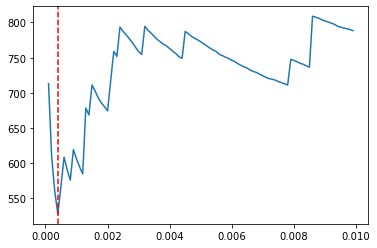

In [69]:
plt.plot(cut_list,fppm_list)
plt.axvline(0.0004, color='r', linestyle = '--')

In [70]:
fig10_3_cut_list = np.arange(0,0.01,0.0001)
fig10_3_fppm_list = np.load('Final_lists/3ndcut_fppm_list.npy')

np.save('../Figure_Data/fig10_3_cut_list.npy', fig10_3_cut_list)
np.save('../Figure_Data/fig10_3_fppm_list.npy', fig10_3_fppm_list)

In [71]:
print('OPTIMAL CUT IS: 0.0004')

OPTIMAL CUT IS: 0.0004


# Getting ROC Curve for Optimal Cuts

In [36]:
from sklearn.metrics import roc_curve

y_pred_keras = []
labels_tot = []

for tdn in total_dataset:
    data, label = tdn
    data = np.expand_dims(data, axis=0)
    prob = model(data).numpy()
    y_pred_keras.extend(1-prob)
    labels_tot.extend(1-label)
    if (len(y_pred_keras) % 3000==0):
        print('Progress report...')

fpr_keras, tpr_keras, thresholds_keras = roc_curve(labels_tot, y_pred_keras)

Progress report...
Progress report...
Progress report...
Progress report...
Progress report...
Progress report...
Progress report...
Progress report...
Progress report...
Progress report...
Progress report...
Progress report...
Progress report...
Progress report...
Progress report...
Progress report...
Progress report...


In [78]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

np.save('../Figure_Data/fig10_ROC_fpr_keras',fpr_keras)
np.save('../Figure_Data/fig10_ROC_tpr_keras',tpr_keras)
np.save('../Figure_Data/fig10_ROC_auc','{:.3f}'.format(auc_keras))

In [77]:
label='{:.3f}'.format(auc_keras)
print(label)

0.885


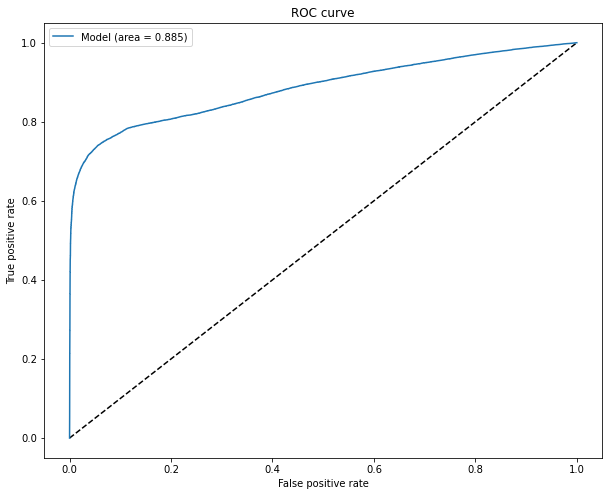

In [72]:
plt.figure(figsize=(10,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Model (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# Saving Cut Data For Plotting

In [48]:
fig10_1_cut_list = [0.001, 0.002, 0.003, 0.004, 0.006, 0.008, 0.01, 0.02, 0.03]
fig10_1_fppm_list = np.load('Final_lists/fppm_list.npy')

np.save('../Figure_Data/fig10_1_cut_list.npy', fig10_1_cut_list)
np.save('../Figure_Data/fig10_1_fppm_list.npy', fig10_1_fppm_list)

In [49]:
fig10_2_cut_list = np.arange(0,0.5,0.001)
fig10_2_fppm_list = np.load('Final_lists/2ndcut_fppm_list.npy')

np.save('../Figure_Data/fig10_2_cut_list.npy', fig10_2_cut_list)
np.save('../Figure_Data/fig10_2_fppm_list.npy', fig10_2_fppm_list)

# Run Tomorrow to Get Values for Optimal Cuts

In [3]:
import tensorflow as tf
from os import listdir
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, LeakyReLU, Dropout

from tensorflow.keras.models import load_model



def data_gen_stack(file_nums, file_type_list, sqrt_scale= None, load_dir = '/vols/lz/lshanahan/data/numpy_noise/'):
    if sqrt_scale == None:
        sqrt_scale = [0 for f in file_type_list]
    for i in file_nums: 
        data = np.stack([np.sqrt(np.load(f'{load_dir}/data_{i}_noise'+f.decode('utf-8')+'.npy')) if s \
                               else np.load(f'{load_dir}/data_{i}_noise'+f.decode('utf-8')+'.npy') \
                               for f,s in zip(file_type_list,sqrt_scale)],axis=-1)
        labels = np.load(f'{load_dir}/labels_{i}.npy').astype(np.int32)
        for j in range(len(labels)):
            yield data[j,:,:,:], labels[j:j+1]
            
file_nums = list(range(18,36))
np.random.shuffle(file_nums)
file_type_list = ['_0.0_threshold', '_2.0_threshold', '_4.0_threshold',]
sqrt_scale = [0,0,0]


total_dataset = tf.data.Dataset.from_generator(data_gen_stack, 
                                        args = (file_nums, file_type_list),
                                        output_shapes=(tf.TensorShape((184,184,len(file_type_list))),tf.TensorShape(1)), 
                                        output_types=(tf.float64,tf.int32))



model = load_model(f'/vols/lz/lshanahan/Big_data/trained_on_obs_mods/obvs_mod_0.006.h5')

prob_list, lab_list = [],[]

for tdn in total_dataset:
    data, label = tdn
    data = np.expand_dims(data, axis=0)
    prob = model(data).numpy()
    prob_list.append(prob)
    lab_list.append(label)
    if (len(lab_list) % 3000==0):
        print('Progress report...')


cut = 0.0004
fps, nrs, mig, cor = [],[],[],[]

for i in range(len(prob_list)):
    if prob_list[i] < cut and lab_list[i] == 1:
        fps.append(i)
    if lab_list[i] == 1:
        nrs.append(i)
    if lab_list[i] == 0:
        mig.append(i)
    if prob_list[i] < cut and lab_list[i] == 0:
        cor.append(i)


print('False Positives: ', len(fps))
print('Number of NRs: ', len(nrs))
print('False Positive Rate: ', len(fps)*100/len(nrs))
print('False Positives per Migdal: ', ((len(fps)/len(nrs))*10e6)/(30*(len(cor)/len(mig))))
print('Accuracy: ', len(cor)*100/len(mig))

2022-09-04 09:40:08.165122: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-04 09:40:08.168456: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-09-04 09:40:08.669324: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-04 09:40:08.669655: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:03.0 name: Quadro RTX 4000 computeCapability: 7.5
coreClock: 1.545GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 387.49GiB/s
2022-09-04 09:40:08.669687: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-09-04 09:40:09.202132: I tensorflow/stream_executor/platform/default/ds

Progress report...
Progress report...
Progress report...
Progress report...
Progress report...
Progress report...
Progress report...
Progress report...
Progress report...
Progress report...
Progress report...
Progress report...
Progress report...
Progress report...
Progress report...
Progress report...
Progress report...
False Positives:  8
Number of NRs:  29446
False Positive Rate:  0.027168376010323982
False Positives per Migdal:  528.1592527169317
Accuracy:  17.14658086588197


In [8]:
import tensorflow as tf
from os import listdir
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, LeakyReLU, Dropout

from tensorflow.keras.models import load_model



def data_gen_stack(file_nums, file_type_list, sqrt_scale= None, load_dir = '/vols/lz/lshanahan/data/numpy_noise/'):
    if sqrt_scale == None:
        sqrt_scale = [0 for f in file_type_list]
    for i in file_nums: 
        data = np.stack([np.sqrt(np.load(f'{load_dir}/data_{i}_noise'+f.decode('utf-8')+'.npy')) if s \
                               else np.load(f'{load_dir}/data_{i}_noise'+f.decode('utf-8')+'.npy') \
                               for f,s in zip(file_type_list,sqrt_scale)],axis=-1)
        labels = np.load(f'{load_dir}/labels_{i}.npy').astype(np.int32)
        for j in range(len(labels)):
            yield data[j,:,:,:], labels[j:j+1]
            
file_nums = list(range(18,36))
np.random.shuffle(file_nums)
file_type_list = ['_0.0_threshold', '_2.0_threshold', '_4.0_threshold',]
sqrt_scale = [0,0,0]


total_dataset = tf.data.Dataset.from_generator(data_gen_stack, 
                                        args = (file_nums, file_type_list),
                                        output_shapes=(tf.TensorShape((184,184,len(file_type_list))),tf.TensorShape(1)), 
                                        output_types=(tf.float64,tf.int32))



model = load_model(f'/vols/lz/lshanahan/Big_data/trained_on_obs_mods/obvs_mod_0.006.h5')

prob_list, lab_list = [],[]

for tdn in total_dataset:
    data, label = tdn
    data = np.expand_dims(data, axis=0)
    prob = model(data).numpy()
    prob_list.append(prob)
    lab_list.append(label)
    if (len(lab_list) % 3000==0):
        print('Progress report...')


cut = 0.15
fps, nrs, mig, cor = [],[],[],[]

for i in range(len(prob_list)):
    if prob_list[i] < cut and lab_list[i] == 1:
        fps.append(i)
    if lab_list[i] == 1:
        nrs.append(i)
    if lab_list[i] == 0:
        mig.append(i)
    if prob_list[i] < cut and lab_list[i] == 0:
        cor.append(i)


print('False Positives: ', len(fps))
print('Number of NRs: ', len(nrs))
print('False Positive Rate: ', len(fps)*100/len(nrs))
print('False Positives per Migdal: ', ((len(fps)/len(nrs))*10e6)/(30*(len(cor)/len(mig))))
print('Accuracy: ', len(cor)*100/len(mig))

Progress report...
Progress report...
Progress report...
Progress report...
Progress report...
Progress report...
Progress report...
Progress report...
Progress report...
Progress report...
Progress report...
Progress report...
Progress report...
Progress report...
Progress report...
Progress report...
Progress report...
False Positives:  53
Number of NRs:  29446
False Positive Rate:  0.17999049106839637
False Positives per Migdal:  1230.7646217178647
Accuracy:  48.74760721704069
